<a href="https://colab.research.google.com/github/AnhVanGiang/MO/blob/main/Third_assignment_Mathematical_optimization_2022_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Third assigment - Mathematical Optimization 2022-2023
The third assignment consists of 3 parts, worth 20, 35, and 35 points respectively, for a total of 90 points available. The final assignment grade is determined by `(# points / 10) + 1`.


## Setup
We import here all libraries and solvers needed for the entire assignment. The only solver necessary is `cbc`, make sure to use only this one!

In [1]:
# Running this cell for the first time might yield a warning message. 
# Ignore it, rerun this cell another time, and then proceed with the rest of the notebook.

try:
    import osmnx
except:
    import os
    _=!pip install osmnx
    os.kill(os.getpid(), 9)

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import httpimport

with httpimport.github_repo('alessandrozocca', 'MO2022', 'helpers'):
    from helpers import installer    

    if installer.on_colab():
        installer.install_pyomo()
        installer.install_cbc()

    from helpers.assignment3 import get_network, make_instance, get_route
    from helpers.assignment3 import get_distances_to, get_crowdedness
    from helpers.assignment3 import plot_network, plot_network_heatmap

Installing pyomo from idaes_pse via pip ... installation successful
Installing cbc on Google Colab via zip file ... installation successful


In [3]:
import numpy as np
import pyomo.environ as pyo
from IPython.display import Markdown

# Motivation: a very efficient and quick tour in Venice

<div>
<img src="https://cdn.britannica.com/63/153463-050-06B6270D/Grand-Canal-Venice.jpg" width="600"/>
</div>

Jasper will be in Venice only for a few hours before his flight leaves and he absolutely wants to visit the St. Mark Basilica. To do so, he wants to find the shortest path from the Venice Santa Lucia railway station to San Marco Square, where the famous [St. Mark's Basilica](https://en.wikipedia.org/wiki/St_Mark%27s_Basilica) is. To get a better sense of his challenge, below you can see a map of Venice. The starting point is Venice Santa Lucia railway station (*Stazione di Venezia Santa Lucia*) in the top left, with the target destination, St. Mark Basilica, is the dropped red pin in the right part of the map.

<div>
<img src="https://github.com/alessandrozocca/MO2022/raw/main/helpers/venicemap.png" width="600"/>
</div>

## Data import 

In order to find the shortest path, we need to import all the relevant data and parameters. First of all, the labels corresponding to the starting node $s$ and target node $t$ are given as:

- `s` = Santa Lucia Railway Station (label: 3527984781)
- `t` = San Marco Square (label: 9645230124)

and should be considered as fixed for the rest of the assignment.

Jasper coded a few functions to download the road network of Venice as a directed weighted graph $G=(V,E)$. Every walkable street is described by means by two directed edges (one per direction) and to which is associated a weight that corresponds to the length of that street in meters. 

The function `get_network` imports the street network of the portion of the city of Venice that is relevant for Jasper's challenge.

The function `make_instance` creates the collections of nodes, (directed and weighted) edges, and node neighbors that we need to implement the shortest path problem as a min-cost flow network problem.

The function `plot_network` visualizes the street network using the true spatial coordinates and we be used to visualize any desired route. In the following code cell, we use it to show the location of the starting node in blue and that of the target node in red.

**PLEASE DO NOT CHANGE** the starting and target nodes `s` and `t` nor the arguments `center` and `radius` of the get_network function, as it may make the rest of the problem in the notebook infeasible or too large to be solved.

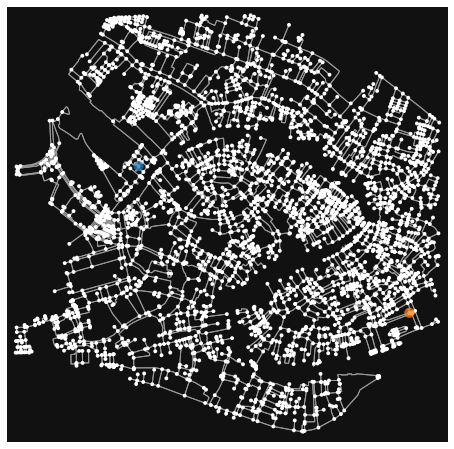

In [4]:
s = 3527984781      # Santa Lucia Railway Station
t = 9645230124      # San Marco Square

network = get_network(center='Campo San Stin, Venezia, Italy', radius=1100)
nodes, edges, pred, succ = make_instance(network)

plot_network(network, [s], [t])

## ILP formulation of the Shortest Path problem

Given a street network $G=(V,E)$, denote by $c_{ij}>0$ be the weight of the edge $(i,j) \in E$, which describe the length of the corresponding street. 
For given starting node $s \in V$ and ending node $t \in V$ nodes, the shortest path (SP) problem aims to determine the path from $s$ to $t$ through the network that minimizes the total travel time, in Jasper's case the total walking distance. The shortest path is a special case of the min-cost flow problem and can be written as the following ILP:

\begin{align*}
    \min \quad &\sum_{(i,j) \in E} c_{ij} x_{ij} \\
    \text{s.t.} \quad &\sum_{i : (j,i) \in E} x_{ji} - \sum_{i : (i,j) \in E} x_{ij} = b_j, & \forall\, j \in V, \\
    & x_{ij} \in \{0,1\} & \forall\, (i,j) \in E,%
\end{align*}

with

$$
  b_j = 
  \begin{cases}
    1, & \text{for } j=s, \\
    -1, & \text{for } j=t, \\
    0, & \text{otherwise.}
  \end{cases}
$$

Note that this formulation assumes that all the edges are directed. In particular, this means that if $x_{ij}=1$ means that the edge $(i,j)$ is traversed from node $i$ to node $j$, while if $x_{ji}=1$ means that the edge $(j,i)$ is traversed from node $j$ to node $i$. Every pair of neighboring nodes have two directed edges connecting them, one per direction.

Assuming that a person walks at a constant speed, note that we can equivalently think of $c_{ij}$ also as the travel time to cross edge $(i,j)$.

## Base model: deterministic SP as an ILP

Consider the following ILP implementation of the deterministic SP problem.

In [5]:
def shortest_path_model(s, t, nodes, edges, pred, succ):

    model = pyo.ConcreteModel('Deterministic Shortest Path')

    # starting node and target node are implemented as parameter
    model.s = pyo.Param(initialize=s)
    model.t = pyo.Param(initialize=t)

    model.nodes = pyo.Set(initialize=nodes)
    model.edges = pyo.Set(initialize=list(edges.keys()))

    model.x = pyo.Var(model.edges, domain=pyo.Binary)

    @model.Objective()
    def total_distance(m):
        return sum(m.x[i, j] * edges[i, j] for i, j in m.edges)

    @model.Expression(model.nodes)
    def incoming(m, j):
        return sum(m.x[j, i] for i in pred[j])

    @model.Expression(model.nodes)
    def outgoing(m, j):
        return sum(m.x[i, j] for i in succ[j])

    @model.Expression(model.nodes)
    def b(m, j):
        return (j in {s, t}) * (-1) ** (j == t)

    @model.Constraint(model.nodes)
    def flow(m, j):
        return m.incoming[j] - m.outgoing[j] == m.b[j]

    return model

Being a ILP, we can solve it using the open-source `cbc` solver.

In [6]:
cbc_solver = pyo.SolverFactory('cbc')

As illustrated in the code below, the `get_route` function extracts the optimal route from the output of the solver and the `plot_network` function visualizes it in red over the network of the entire city.

The shortest path has length 2254.92



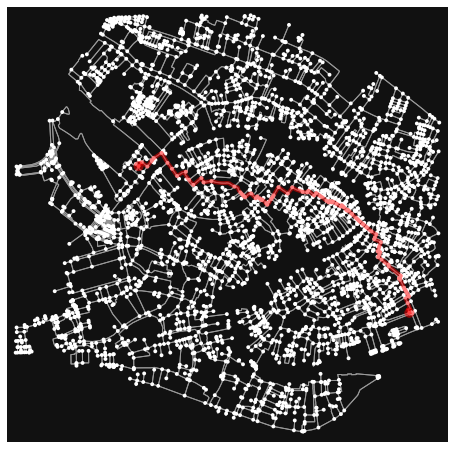

In [7]:
model = shortest_path_model(s, t, nodes, edges, pred, succ)
result = cbc_solver.solve(model)

print(f"The shortest path has length %.2f\n" % model.total_distance())
route = get_route(model)
plot_network(network, route)

# Part 1: Avoiding the crowd around the Rialto bridge





<div>
<img src="https://github.com/alessandrozocca/MO2022/raw/main/helpers/rialtobridge.png" width="600"/>
</div>

Jasper knows that the area around the Rialto bridge is always very crowded by tourists and he think he should better avoid it, even if the deterministic shortest path found earlier precisely crosses that bridge.

Jasper believes that it can make his path faster it is enough to avoid *the area around the Rialto bridge*. More precisely, he wants to calculate the shortest path that keeps a safe distance larger than $\delta$ from the Rialto bridge at all times. More specifically, we want our route *not* to go through nodes which are at distance $\delta$ or lower from the Rialto bridge (node $5395065019$).

For a given $\delta$, the following code snippet depicts in red all nodes that are at distance less than or equal to $\delta$.

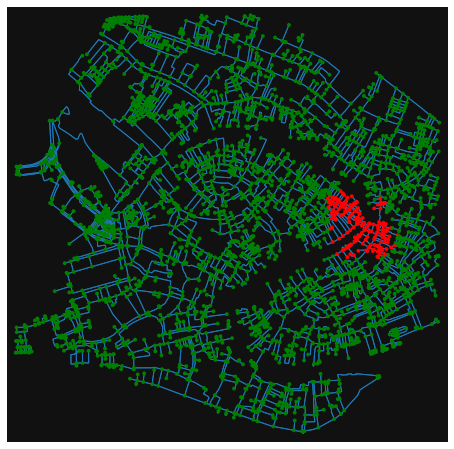

In [8]:
rialto = 5395065019
dist = get_distances_to(network, rialto)

delta = 250
plot_network_heatmap(network, node_color=["g" if dist[i] > delta else "r" for i in network.nodes])

 ## Questions part 1 [20 points]

 1. [5 points] Using the mathematical notation presented above, write down mathematically the constraint that prevents the paths from visiting any node $i$ at distance $d(i)$ in meters less than or equal to $\delta$ from the Rialto bridge.

 2. [10 points] For any distance $\delta$, leveraging the provided base SP model, define a new deterministic `pyomo` model that takes $\delta$ as parameter and finds the shortest path that does not visit any node at distance less than or equal to $\delta$ from the Rialto bridge. 
 
  **Note**: you should use the pre-calculated vector `dist` of distances (in meters) of all nodes from the Rialto bridge node.

  *Hint: use the* `plot_network_heatmap` *function above to convince you that your model works correctly.*
 
 3. [5 points] Solve the model for various $\delta$. Try at least the following five values of $\delta \in \{0, 50, 100, 400, 600\}$. Does the optimal route change? If so, how? 

## Solution part 1

### Question 1.1

The constraint is 
$$ x_{ji} \cdot d(i) < \delta$$
for all $i \in V$. This makes sense because for nodes that are too close, $d(i) \geq \delta$ and if we visit that node, $x_{ji} = 1$ then it follows that $d(i) < \delta$ would be violated. 

### Questions 1.2

In [ ]:
def safe_shortest_path_model(s, t, nodes, edges, pred, succ, dist, delta):

    model = shortest_path_model(s, t, nodes, edges, pred, succ)

    # add constraints that ensure the shortest path does not visit
    # nodes that are at distance less than or equal to delta 

    return model

### Questions 1.3

In [ ]:
# Solve safe_shortest_path_model for various values of delta

# Part 2: Robust shortest path

Unsatisfied with the solutions from part 1 that seem to prescribe too long routes, Jasper is determined to improve them. Instead of strictly forbidding all the nodes around the Rialto bridge, he estimated how much it expects each node of the network to be congested and wants to use this information to find a **robust shortest path**.

As mentioned earlier, assuming that Jasper walks at a constant speed, we can equivalently think of the edge weight $c_{ij}$ also as the travel time to cross edge $(i,j)$. 

In part 2, we assume now that, due to congestion, the travel time of each edge $(i,j) \in E$ is not deterministic anymore, but is affected by uncertainty. In part 2, you can assume that the travel time on edge $(i,j)$ is equal to 

$$c_{i,j} (1+ z_{ij})$$

where $c_{i,j}$ was the original deterministic travel time and $z_{ij}$ is an uncertain congestion factor that lies in the interval 

$$z_{ij} \in [0, \alpha_{i} + \alpha_{j}].$$

The quantity $\alpha_{i} \geq 0$ is the **traffic congestion coefficient** of node $i$. The assumption above means that the upper bound of the interval for the uncertain parameter $z_{ij}$ depends on the values of the traffic congestion coefficients at both the endpoints $i$ and $j$ of the corresponding edge.

The following code cells imports the vector `alpha` with all the traffic congestion coefficients and displays a heatmap that shows where these are larger with lighter colors.

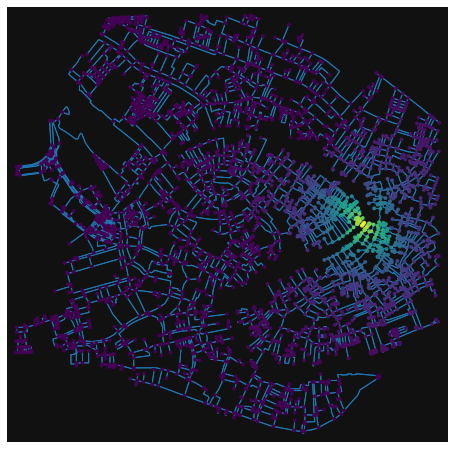

In [ ]:
alpha = get_crowdedness(network)
plot_network_heatmap(network, node_color=[alpha[k] for k in nodes])

## Questions part 2 [35 pts]

  1. [5 pts] Explain mathematically how you can move the uncertainty from the objective function into a constraint and write in full the resulting ILP.

  2. [15 pts] Which type of uncertainty set do the uncertain parameter $z_{ij}$'s vary in? Derive the robust counterpart of the constraint affected by uncertainty in view of the assumption described above for part 2.

  3. [15 pts] Using your answer to question (2), implement a `pyomo` concrete model of the robust stochastic problem and solve it for the same network instance, starting node and target node as in part 1. Compare the optimal robust shortest path with the deterministic shortest path and the one you obtained in part 1.

## Solution part 2

### Question 2.1

### Question 2.2

### Question 2.3

In [ ]:
def robust_shortestpath(s, t, nodes, edges, pred, succ, alpha):

    model = pyo.ConcreteModel('Robust Shortest Path')

    # define here your robust model using your answers from questions (1) and (2)

    return model

In [ ]:
model = robust_shortestpath(s, t, nodes, edges, pred, succ, alpha)
result = cbc_solver.solve(model)
route = get_route(model)

print(f"\nThe optimal robust shortest path has length %.2f\n" % model.total_distance())
plot_network(network, route)

# Part 3: Robust shortest path with budget uncertainty set

Jasper realizes that his solution from part 2 might still be too pessimistic. Indeed, it is a bit unrealistic to assume that all travel times simultaneously get worse. For part 3, we want to refine our robust shortest path by considering a budget uncertainty set that allows us to tune how many streets can simultaneously be congested. 

Specifically, given a positive integer $\Gamma\in \mathbb{N}_+$, we assume that the travel time on edge $(i,j) \in E$ is equal to

$$c_{ij}(1+z_{ij}),$$

where the vector of uncertain factors $\mathbf{z}=(z_{ij})_{(i,j) \in E}$ belongs to the following budget uncertainty set

$$
Z_\mathrm{budget}(\Gamma) = \Big \{  \mathbf{z} \in \mathbb{R}^{|E|} ~:~ |z_{ij}| \leq 1 \text{ and } \sum_{(i,j) \in E} | z_{ij} | \leq \Gamma \Big \}.
$$

## Questions part 3 [35 pts]

  1. [10 pts] Given the provided budget uncertainty set, write explicitly in mathematical terms the robust counterpart of the unique constraint of the SP problem that affected by uncertainty. 

    *N.B.: You are not required to derive it from scratch using duality, but you are required to justify your steps, e.g. by explaining which formulas you are using and why.*

  2. [15 pts] Using your answer to question (1), implement a ```pyomo``` concrete model of this second version of the robust shortest path, and solve it multiple times using different values for the parameter $\Gamma \in \{0, 5, 10, 20\}$. Do the solutions differ from that of the deterministic SP? Do solutions corresponding to different $\Gamma$'s differ from each other? 

  3. [10 pts] Answer again both questions (1) and (2), but assuming now that the budget uncertainty set is
$$
Z^*_\mathrm{budget}(\Gamma) = \Big \{  \mathbf{z} \in \mathbb{R}^{|E|} ~:~ |z_{ij}| \leq \alpha_i + \alpha_j \text{ and } \sum_{(i,j) \in E} | z_{ij} | \leq \Gamma \Big \}
$$
where the numerical values of the congestion coefficients $\alpha_i$'s are the same as those provided in part 2.

## Solutions part 3

### Question 3.1

### Question 3.2

In [ ]:
def shortestpath_budgetuncertainty(s, t, nodes, edges, pred, succ, Gamma):

    model = pyo.ConcreteModel('SP with budget uncertainty set')

    # define here your robust model using the answer from question (1)

    return model

### Question 3.3

In [ ]:
# define here a new variant of the robust model using the new uncertainty set